In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd
from scipy.ndimage import gaussian_filter1d

from epistatic_net.wht_sampling import SPRIGHTSample
from epistatic_net.spright_utils import SPRIGHT, make_system_simple

from utils import ModelTrainer
from datasets import FourierDataset

# Set seeds
random_seed = 55
fix_seed = 3
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [2]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

In [88]:
sample_seed = 2222
test_n = 10
test_k = 5
test_d = 5
test_b = 3
dataset_size_coef = 1
test_n_samples =  2**test_n

# dataset = FourierDataset(n=test_n, k=test_k, d=test_d, n_samples=test_n_samples, random_seed=fix_seed,
#                         freq_sampling_method="uniform_deg", amp_sampling_method="constant")
dataset = FourierDataset(n=test_n, k=test_k, n_samples=test_n_samples, random_seed=sample_seed, freq_seed=fix_seed,
                        freq_sampling_method="single_deg", amp_sampling_method="constant")

print(sorted(dataset.get_int_freqs()))
print(sorted(dataset.amp_f))
print(dataset.X.shape)

[24, 208, 307, 480, 512]
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]
torch.Size([1024, 10])


In [89]:
dataset.X[:10], dataset.y[:10]

(tensor([[1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
         [1., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
         [1., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 0., 1., 1., 0., 0., 1., 0., 1., 1.],
         [0., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
         [0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 1., 1., 0., 1.]]),
 tensor([-0.2000,  0.2000, -0.2000, -0.6000,  0.6000,  0.2000, -0.2000,  0.2000,
          0.2000,  0.2000]))

In [75]:
train_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n)))
val_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n, test_n_samples)))
print(len(train_ds), len(val_ds))

50 974


#0 - Train Loss: 0.335, R2: -1.292	Validation Loss: 0.302, R2: -0.499
#1 - Train Loss: 0.151, R2: -0.031	Validation Loss: 0.201, R2: 0.001
#2 - Train Loss: 0.153, R2: -0.047	Validation Loss: 0.208, R2: -0.034
#3 - Train Loss: 0.123, R2: 0.157	Validation Loss: 0.269, R2: -0.336
#4 - Train Loss: 0.120, R2: 0.181	Validation Loss: 0.282, R2: -0.404
#5 - Train Loss: 0.105, R2: 0.284	Validation Loss: 0.218, R2: -0.082
#6 - Train Loss: 0.088, R2: 0.396	Validation Loss: 0.192, R2: 0.046
#7 - Train Loss: 0.091, R2: 0.378	Validation Loss: 0.202, R2: -0.002
#8 - Train Loss: 0.079, R2: 0.457	Validation Loss: 0.248, R2: -0.232
#9 - Train Loss: 0.071, R2: 0.512	Validation Loss: 0.262, R2: -0.302
#10 - Train Loss: 0.064, R2: 0.560	Validation Loss: 0.224, R2: -0.115
#11 - Train Loss: 0.055, R2: 0.626	Validation Loss: 0.207, R2: -0.026
#12 - Train Loss: 0.052, R2: 0.644	Validation Loss: 0.218, R2: -0.081
#13 - Train Loss: 0.044, R2: 0.698	Validation Loss: 0.247, R2: -0.226
#14 - Train Loss: 0.041, R2: 

#135 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.249, R2: -0.236
#136 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.244, R2: -0.215
#137 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.246, R2: -0.222
#138 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.246, R2: -0.224
#139 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.247, R2: -0.230
#140 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.245, R2: -0.215
#141 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.249, R2: -0.236
#142 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.242, R2: -0.204
#143 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.253, R2: -0.257
#144 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.242, R2: -0.203
#145 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.248, R2: -0.231
#146 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.249, R2: -0.235
#147 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.242, R2: -0.201
#148 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.254, R2: -0.263
#149 -

#263 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#264 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.195
#265 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.197
#266 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#267 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#268 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.197
#269 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#270 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#271 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.197
#272 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#273 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#274 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.197
#275 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#276 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#277 -

#379 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#380 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#381 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#382 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#383 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#384 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#385 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#386 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#387 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#388 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#389 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#390 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#391 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#392 - Train Loss: 0.000, R2: 1.000	Validation Loss: 0.241, R2: -0.196
#393 -

#104 - Train Loss: 0.002, R2: 0.987	Validation Loss: 0.171, R2: 0.152
#105 - Train Loss: 0.002, R2: 0.988	Validation Loss: 0.184, R2: 0.085
#106 - Train Loss: 0.004, R2: 0.971	Validation Loss: 0.171, R2: 0.153
#107 - Train Loss: 0.003, R2: 0.981	Validation Loss: 0.173, R2: 0.143
#108 - Train Loss: 0.002, R2: 0.986	Validation Loss: 0.175, R2: 0.132
#109 - Train Loss: 0.003, R2: 0.983	Validation Loss: 0.169, R2: 0.162
#110 - Train Loss: 0.003, R2: 0.978	Validation Loss: 0.188, R2: 0.066
#111 - Train Loss: 0.004, R2: 0.971	Validation Loss: 0.176, R2: 0.126
#112 - Train Loss: 0.003, R2: 0.983	Validation Loss: 0.165, R2: 0.179
#113 - Train Loss: 0.003, R2: 0.981	Validation Loss: 0.185, R2: 0.079
#114 - Train Loss: 0.004, R2: 0.973	Validation Loss: 0.175, R2: 0.130
#115 - Train Loss: 0.004, R2: 0.976	Validation Loss: 0.169, R2: 0.160
#116 - Train Loss: 0.002, R2: 0.983	Validation Loss: 0.186, R2: 0.078
#117 - Train Loss: 0.003, R2: 0.979	Validation Loss: 0.173, R2: 0.140
#118 - Train Loss: 0

#222 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.172, R2: 0.145
#223 - Train Loss: 0.001, R2: 0.990	Validation Loss: 0.178, R2: 0.117
#224 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.179, R2: 0.110
#225 - Train Loss: 0.001, R2: 0.990	Validation Loss: 0.177, R2: 0.120
#226 - Train Loss: 0.002, R2: 0.989	Validation Loss: 0.178, R2: 0.114
#227 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.177, R2: 0.119
#228 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.176, R2: 0.128
#229 - Train Loss: 0.001, R2: 0.990	Validation Loss: 0.178, R2: 0.115
#230 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.179, R2: 0.110
#231 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.176, R2: 0.127
#232 - Train Loss: 0.001, R2: 0.990	Validation Loss: 0.176, R2: 0.126
#233 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.178, R2: 0.113
#234 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.177, R2: 0.118
#235 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.176, R2: 0.127
#236 - Train Loss: 0

#342 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.179, R2: 0.109
#343 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.181, R2: 0.099
#344 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.179, R2: 0.110
#345 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.178, R2: 0.115
#346 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.180, R2: 0.103
#347 - Train Loss: 0.001, R2: 0.991	Validation Loss: 0.182, R2: 0.098
#348 - Train Loss: 0.001, R2: 0.992	Validation Loss: 0.181, R2: 0.099
#349 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.181, R2: 0.102
#350 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.180, R2: 0.104
#351 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.181, R2: 0.099
#352 - Train Loss: 0.001, R2: 0.992	Validation Loss: 0.183, R2: 0.091
#353 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.182, R2: 0.095
#354 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.180, R2: 0.104
#355 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.180, R2: 0.106
#356 - Train Loss: 0

#64 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.205, R2: -0.019
#65 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.207, R2: -0.028
#66 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.202, R2: -0.003
#67 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.206, R2: -0.022
#68 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.203, R2: -0.008
#69 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.207, R2: -0.029
#70 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.206, R2: -0.026
#71 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.201, R2: 0.004
#72 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.208, R2: -0.036
#73 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.197, R2: 0.022
#74 - Train Loss: 0.001, R2: 0.991	Validation Loss: 0.203, R2: -0.007
#75 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.207, R2: -0.028
#76 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.194, R2: 0.035
#77 - Train Loss: 0.001, R2: 0.992	Validation Loss: 0.201, R2: -0.001
#78 - Train Loss: 0.001

#181 - Train Loss: 0.007, R2: 0.954	Validation Loss: 0.356, R2: -0.770
#182 - Train Loss: 0.008, R2: 0.944	Validation Loss: 0.493, R2: -1.449
#183 - Train Loss: 0.011, R2: 0.927	Validation Loss: 0.424, R2: -1.108
#184 - Train Loss: 0.006, R2: 0.961	Validation Loss: 0.398, R2: -0.978
#185 - Train Loss: 0.009, R2: 0.937	Validation Loss: 0.457, R2: -1.273
#186 - Train Loss: 0.006, R2: 0.958	Validation Loss: 0.328, R2: -0.628
#187 - Train Loss: 0.020, R2: 0.861	Validation Loss: 0.369, R2: -0.833
#188 - Train Loss: 0.011, R2: 0.923	Validation Loss: 0.373, R2: -0.852
#189 - Train Loss: 0.006, R2: 0.960	Validation Loss: 0.302, R2: -0.502
#190 - Train Loss: 0.005, R2: 0.966	Validation Loss: 0.322, R2: -0.599
#191 - Train Loss: 0.006, R2: 0.960	Validation Loss: 0.321, R2: -0.593
#192 - Train Loss: 0.004, R2: 0.971	Validation Loss: 0.297, R2: -0.474
#193 - Train Loss: 0.003, R2: 0.981	Validation Loss: 0.311, R2: -0.544
#194 - Train Loss: 0.004, R2: 0.974	Validation Loss: 0.305, R2: -0.518
#195 -

#298 - Train Loss: 0.001, R2: 0.992	Validation Loss: 0.221, R2: -0.099
#299 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.216, R2: -0.073
#300 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.217, R2: -0.077
#301 - Train Loss: 0.002, R2: 0.988	Validation Loss: 0.221, R2: -0.101
#302 - Train Loss: 0.002, R2: 0.989	Validation Loss: 0.220, R2: -0.094
#303 - Train Loss: 0.001, R2: 0.996	Validation Loss: 0.212, R2: -0.054
#304 - Train Loss: 0.002, R2: 0.988	Validation Loss: 0.215, R2: -0.069
#305 - Train Loss: 0.001, R2: 0.994	Validation Loss: 0.224, R2: -0.112
#306 - Train Loss: 0.002, R2: 0.986	Validation Loss: 0.217, R2: -0.077
#307 - Train Loss: 0.001, R2: 0.993	Validation Loss: 0.213, R2: -0.057
#308 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.218, R2: -0.081
#309 - Train Loss: 0.001, R2: 0.995	Validation Loss: 0.217, R2: -0.080
#310 - Train Loss: 0.001, R2: 0.992	Validation Loss: 0.217, R2: -0.080
#311 - Train Loss: 0.002, R2: 0.989	Validation Loss: 0.221, R2: -0.100
#312 -

#30 - Train Loss: 0.021, R2: 0.856	Validation Loss: 0.187, R2: 0.072
#31 - Train Loss: 0.020, R2: 0.863	Validation Loss: 0.193, R2: 0.039
#32 - Train Loss: 0.018, R2: 0.874	Validation Loss: 0.189, R2: 0.063
#33 - Train Loss: 0.017, R2: 0.881	Validation Loss: 0.184, R2: 0.085
#34 - Train Loss: 0.017, R2: 0.882	Validation Loss: 0.192, R2: 0.044
#35 - Train Loss: 0.019, R2: 0.871	Validation Loss: 0.191, R2: 0.049
#36 - Train Loss: 0.016, R2: 0.891	Validation Loss: 0.195, R2: 0.029
#37 - Train Loss: 0.015, R2: 0.895	Validation Loss: 0.182, R2: 0.097
#38 - Train Loss: 0.019, R2: 0.871	Validation Loss: 0.184, R2: 0.085
#39 - Train Loss: 0.017, R2: 0.884	Validation Loss: 0.194, R2: 0.038
#40 - Train Loss: 0.016, R2: 0.888	Validation Loss: 0.175, R2: 0.129
#41 - Train Loss: 0.017, R2: 0.883	Validation Loss: 0.187, R2: 0.073
#42 - Train Loss: 0.014, R2: 0.906	Validation Loss: 0.191, R2: 0.052
#43 - Train Loss: 0.012, R2: 0.918	Validation Loss: 0.176, R2: 0.127
#44 - Train Loss: 0.014, R2: 0.906

#159 - Train Loss: 0.005, R2: 0.966	Validation Loss: 0.140, R2: 0.303
#160 - Train Loss: 0.007, R2: 0.952	Validation Loss: 0.147, R2: 0.271
#161 - Train Loss: 0.005, R2: 0.965	Validation Loss: 0.146, R2: 0.274
#162 - Train Loss: 0.006, R2: 0.960	Validation Loss: 0.138, R2: 0.316
#163 - Train Loss: 0.006, R2: 0.956	Validation Loss: 0.146, R2: 0.273
#164 - Train Loss: 0.005, R2: 0.966	Validation Loss: 0.141, R2: 0.300
#165 - Train Loss: 0.006, R2: 0.958	Validation Loss: 0.140, R2: 0.306
#166 - Train Loss: 0.006, R2: 0.958	Validation Loss: 0.143, R2: 0.291
#167 - Train Loss: 0.005, R2: 0.967	Validation Loss: 0.142, R2: 0.295
#168 - Train Loss: 0.006, R2: 0.962	Validation Loss: 0.142, R2: 0.293
#169 - Train Loss: 0.006, R2: 0.956	Validation Loss: 0.139, R2: 0.307
#170 - Train Loss: 0.007, R2: 0.955	Validation Loss: 0.139, R2: 0.307
#171 - Train Loss: 0.005, R2: 0.969	Validation Loss: 0.141, R2: 0.298
#172 - Train Loss: 0.005, R2: 0.968	Validation Loss: 0.133, R2: 0.338
#173 - Train Loss: 0

#280 - Train Loss: 0.004, R2: 0.970	Validation Loss: 0.112, R2: 0.442
#281 - Train Loss: 0.005, R2: 0.964	Validation Loss: 0.105, R2: 0.479
#282 - Train Loss: 0.007, R2: 0.949	Validation Loss: 0.111, R2: 0.448
#283 - Train Loss: 0.004, R2: 0.973	Validation Loss: 0.106, R2: 0.476
#284 - Train Loss: 0.006, R2: 0.958	Validation Loss: 0.106, R2: 0.475
#285 - Train Loss: 0.004, R2: 0.972	Validation Loss: 0.116, R2: 0.422
#286 - Train Loss: 0.005, R2: 0.967	Validation Loss: 0.104, R2: 0.483
#287 - Train Loss: 0.010, R2: 0.935	Validation Loss: 0.107, R2: 0.468
#288 - Train Loss: 0.005, R2: 0.964	Validation Loss: 0.116, R2: 0.424
#289 - Train Loss: 0.006, R2: 0.960	Validation Loss: 0.103, R2: 0.487
#290 - Train Loss: 0.007, R2: 0.954	Validation Loss: 0.105, R2: 0.479
#291 - Train Loss: 0.005, R2: 0.964	Validation Loss: 0.109, R2: 0.457
#292 - Train Loss: 0.005, R2: 0.968	Validation Loss: 0.103, R2: 0.490
#293 - Train Loss: 0.005, R2: 0.968	Validation Loss: 0.107, R2: 0.469
#294 - Train Loss: 0

Loading SPRIGHT samples from cache ...
#0 - Train Loss: 0.279, R2: -0.912	Validation Loss: 0.254, R2: -0.264
#1 - Train Loss: 0.149, R2: -0.018	Validation Loss: 0.203, R2: -0.007
#2 - Train Loss: 0.169, R2: -0.154	Validation Loss: 0.209, R2: -0.036
#3 - Train Loss: 0.137, R2: 0.063	Validation Loss: 0.251, R2: -0.249
#4 - Train Loss: 0.125, R2: 0.145	Validation Loss: 0.263, R2: -0.307
#5 - Train Loss: 0.112, R2: 0.236	Validation Loss: 0.220, R2: -0.095
#6 - Train Loss: 0.096, R2: 0.346	Validation Loss: 0.199, R2: 0.012
#7 - Train Loss: 0.093, R2: 0.362	Validation Loss: 0.210, R2: -0.045
#8 - Train Loss: 0.084, R2: 0.424	Validation Loss: 0.229, R2: -0.137
#9 - Train Loss: 0.077, R2: 0.476	Validation Loss: 0.219, R2: -0.086
#10 - Train Loss: 0.069, R2: 0.530	Validation Loss: 0.212, R2: -0.054
#11 - Train Loss: 0.066, R2: 0.549	Validation Loss: 0.214, R2: -0.065
#12 - Train Loss: 0.060, R2: 0.589	Validation Loss: 0.217, R2: -0.080
#13 - Train Loss: 0.056, R2: 0.617	Validation Loss: 0.223, 

#120 - Train Loss: 0.022, R2: 0.852	Validation Loss: 0.214, R2: -0.062
#121 - Train Loss: 0.021, R2: 0.855	Validation Loss: 0.212, R2: -0.056
#122 - Train Loss: 0.021, R2: 0.854	Validation Loss: 0.214, R2: -0.063
#123 - Train Loss: 0.022, R2: 0.848	Validation Loss: 0.212, R2: -0.056
#124 - Train Loss: 0.023, R2: 0.842	Validation Loss: 0.211, R2: -0.049
#125 - Train Loss: 0.024, R2: 0.839	Validation Loss: 0.210, R2: -0.044
#126 - Train Loss: 0.023, R2: 0.839	Validation Loss: 0.210, R2: -0.042
#127 - Train Loss: 0.023, R2: 0.840	Validation Loss: 0.213, R2: -0.056
#128 - Train Loss: 0.024, R2: 0.838	Validation Loss: 0.213, R2: -0.057
#129 - Train Loss: 0.023, R2: 0.843	Validation Loss: 0.210, R2: -0.044
#130 - Train Loss: 0.022, R2: 0.851	Validation Loss: 0.212, R2: -0.053
#131 - Train Loss: 0.021, R2: 0.856	Validation Loss: 0.210, R2: -0.042
#132 - Train Loss: 0.022, R2: 0.848	Validation Loss: 0.214, R2: -0.061
#133 - Train Loss: 0.023, R2: 0.840	Validation Loss: 0.216, R2: -0.075
#134 -

#236 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.041
#237 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#238 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#239 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#240 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#241 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#242 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#243 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#244 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#245 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#246 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#247 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#248 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#249 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#250 -

#357 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#358 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#359 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#360 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#361 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#362 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#363 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#364 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#365 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#366 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#367 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#368 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#369 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#370 - Train Loss: 0.022, R2: 0.847	Validation Loss: 0.210, R2: -0.042
#371 -

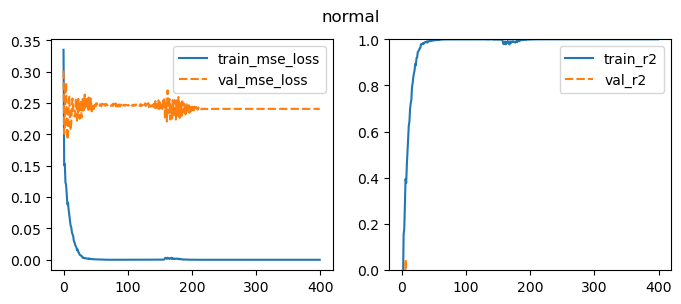

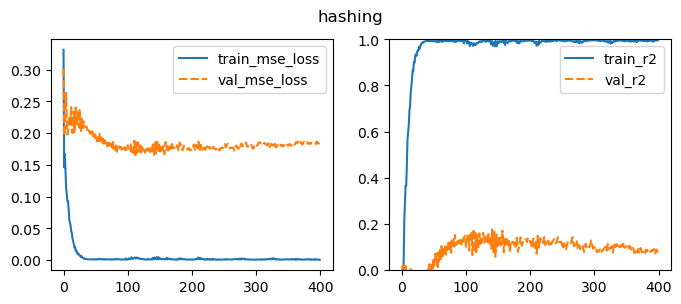

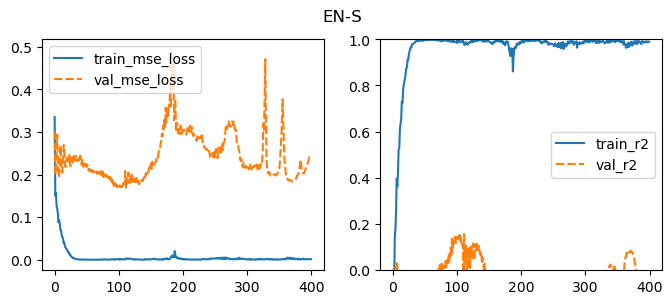

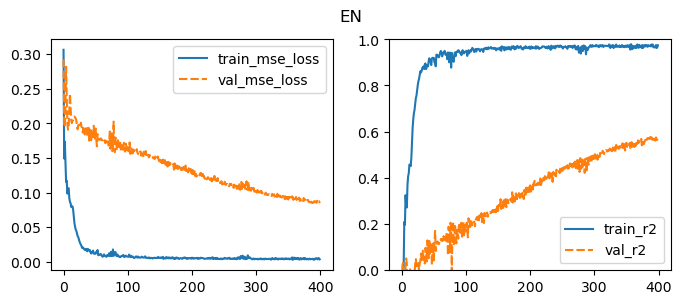

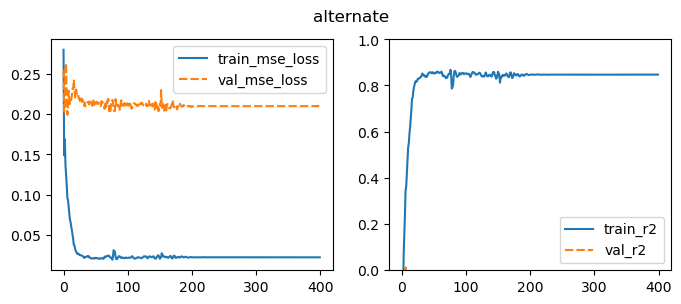

In [90]:
config = {
    "training_method": "normal",
    "add_hadamard_loss": True, 
    "n": test_n,
    "k": test_k,
    "b": test_b + 4,
    "d": test_d,
    "SPRIGHT_d": 5,
    "rho": 0.01,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.001,
    "num_epochs": 400,
    "batch_size": 32,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "fix_deg": True,
    "train_size": len(train_ds),
    "network_c": 10,
    "run": 1,
}

results = {}

# Train model
in_dim = dataset.X.shape[1]
args = {"data_freqs": dataset.get_int_freqs(), "data_spectrum": dataset.get_fourier_spectrum() * (2**(test_n/2) / config["k"])}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "hashing"
config["hadamard_lambda"] = 0.01
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "EN-S"
config["rho"] = 0.01
config["hadamard_lambda"] = 1
config["b"] = test_b
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "EN"
config["hadamard_lambda"] = 1
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

torch.manual_seed(random_seed)
model = FCN(in_dim, config["network_c"])
config["training_method"] = "alternate"
config["hadamard_lambda"] = 1
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums = trainer.train_model()
best = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])+1
results[config["training_method"]] = {"spectrums": spectrums, "best": best}

# Fourier evolution

## Models comparison

/scratch/252423528.tmpdir/ipykernel_192504/4023826564.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


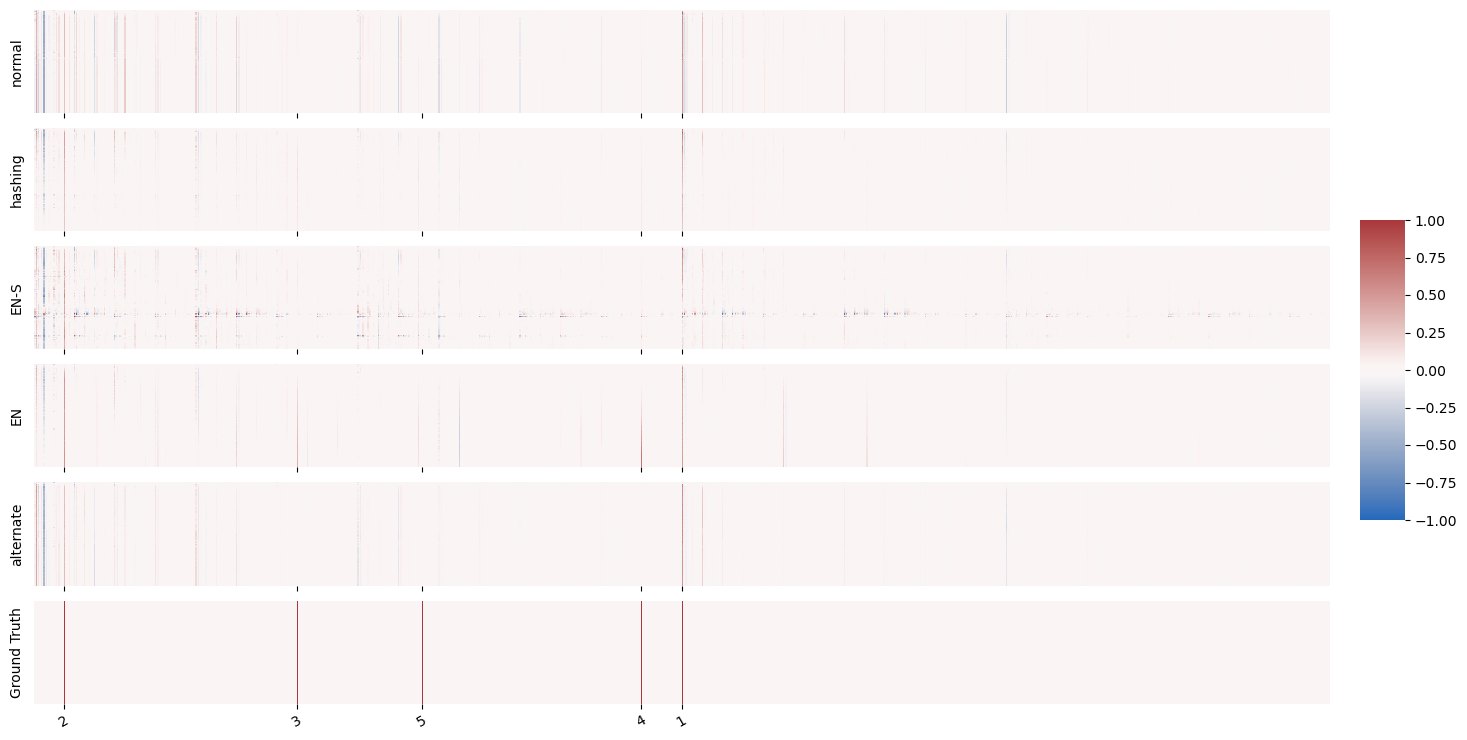

In [77]:
# Plot resltssignificant
fig, axes = plt.subplots(len(results)+1, 1, figsize=(15, len(results)*1.5), sharex=True)

data_range = 1
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, (method, result) in enumerate(results.items()):
    result["normalized_spectrums"] = (np.vstack(result["spectrums"]) / 2**(test_n/2) * test_k)
    sns.heatmap(result["normalized_spectrums"][:, 1:], 
                cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=True if i==0 else False, cbar_ax=cbar_ax)
    axes[i].set_ylabel(method)

# GT
ground_spectrum = dataset.get_fourier_spectrum().reshape(1, -1)
sns.heatmap(ground_spectrum[:, 1:], cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
axes[-1].set_ylabel("Ground Truth")

# Ticks
freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks([x-1 for x in dataset.get_int_freqs()], freq_degrees, rotation=30)
    ax.set_yticks([])

fig.tight_layout(rect=[0, 0, .9, 1])

## Sorted by degree

/scratch/252423528.tmpdir/ipykernel_192504/75842020.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


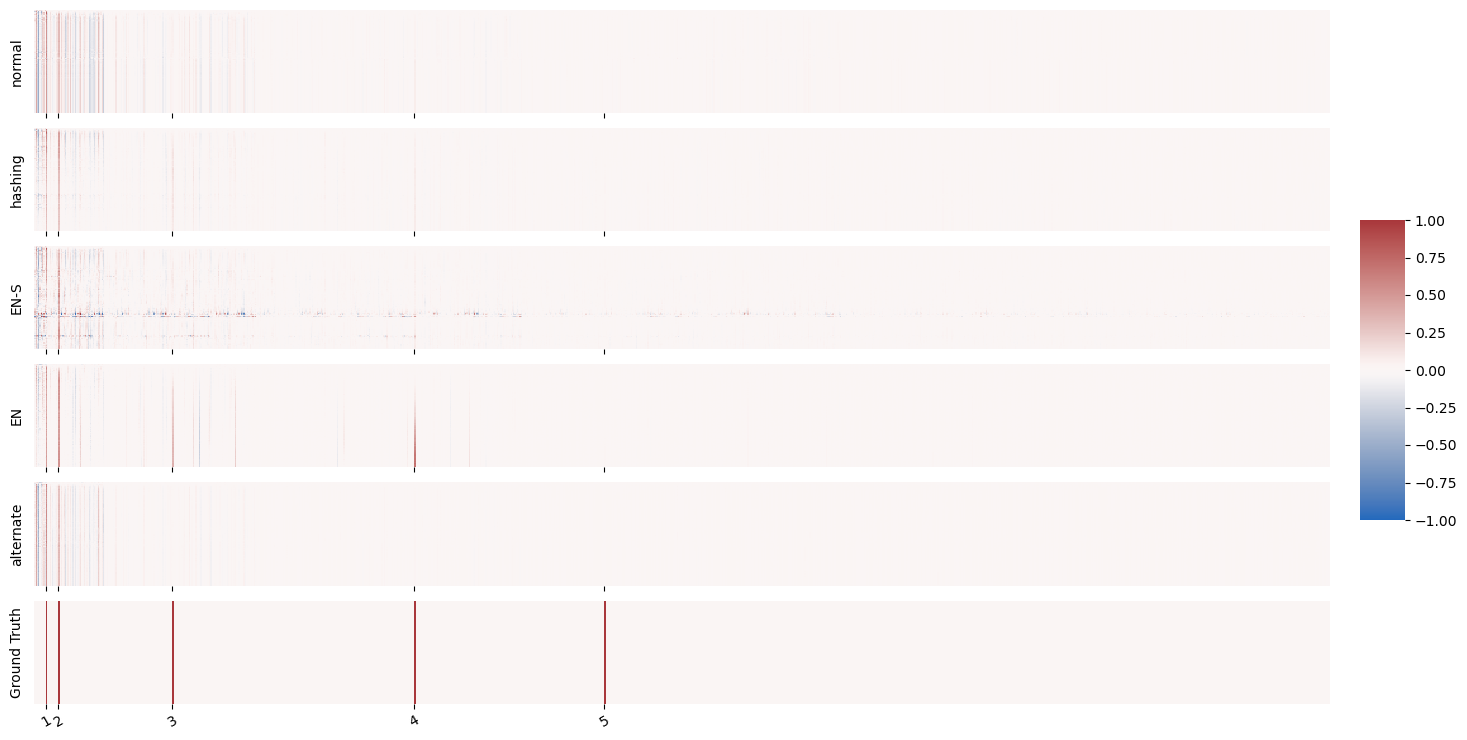

In [78]:
ind_degrees = [(np.binary_repr(i).count('1'), i) for i in range(1 , ground_spectrum.shape[1])]
deg_sorted_ind = [t[1] for t in sorted(ind_degrees)]
sorted_degs = [t[0] for t in sorted(ind_degrees)]
deg_start_inds = [sorted_degs.index(i) for i in range(1, sorted_degs[-1] + 1)]

# Plot reslts
fig, axes = plt.subplots(len(results)+1, 1, figsize=(15, len(results)*1.5), sharex=True)

data_range = 1
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, (method, result) in enumerate(results.items()):
    result["sorted_spectrums"] = result["normalized_spectrums"][:, deg_sorted_ind]
    sns.heatmap(result["sorted_spectrums"][:], 
                cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=True if i==0 else False, cbar_ax=cbar_ax)
    axes[i].set_ylabel(method)

# GT
ground_spectrum_sorted = dataset.get_fourier_spectrum().reshape(1, -1)[:, deg_sorted_ind]
sns.heatmap(ground_spectrum_sorted, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[-1], cbar=False)
axes[-1].set_ylabel("Ground Truth")

# Ticks
freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks([deg_sorted_ind.index(ind) for ind in dataset.get_int_freqs()], freq_degrees, rotation=30)
#     ax.vlines(deg_start_inds[1:], *ax.get_ylim(), color="black", linestyles="dashed")
    ax.set_yticks([])
fig.tight_layout(rect=[0, 0, .9, 1])



## Evolution over dataset frequencies

[512  24 208 480 307]
[9, 19, 109, 300, 450]
[1, 2, 3, 4, 5]
[1. 1. 1. 1. 1.]


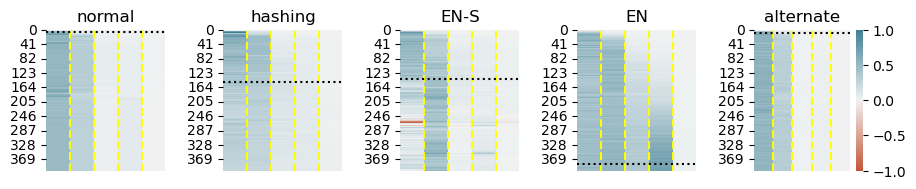

In [79]:
int_freqs = sorted([deg_sorted_ind.index(ind) for ind in dataset.get_int_freqs()])
degs = [sorted_degs[ind] for ind in int_freqs]
seps = [degs.index(i) if i in degs else 0 for i in range(2, degs[-1] + 1)]
print(dataset.get_int_freqs())
print(int_freqs)
print(degs)
print(ground_spectrum_sorted[0, int_freqs])

fig, axes = plt.subplots(1, len(results), figsize=(9, 2))
fig.tight_layout()

data_range = 1
cmap = sns.diverging_palette(20, 220, as_cmap=True)
for i, (method, result) in enumerate(results.items()):
    sns.heatmap(pd.DataFrame(result["sorted_spectrums"][:, int_freqs] / ground_spectrum_sorted[0, int_freqs], columns=degs), 
                cmap=cmap, vmin=-data_range, vmax=data_range, ax=axes[i], 
                cbar=False if i<len(results) -1 else True)
    axes[i].set_title(method)
    axes[i].vlines(seps, *axes[i].get_ylim(), color="yellow", linestyles="dashed")
    axes[i].hlines(result["best"], *axes[i].get_xlim(), color="black", linestyles="dotted")
    axes[i].set_xticks([])


# Energy errors

## Over dataset frequencies

(0.0, 0.6556475782955556)

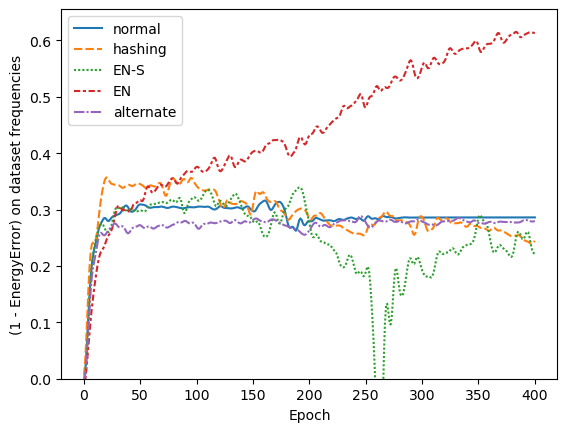

In [80]:
def covered_energy(ground_amps, learned_amps):
    return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)

int_freqs = dataset.get_int_freqs()

data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = [covered_energy(ground_spectrum[0, int_freqs], result["normalized_spectrums"][epoch, int_freqs]) 
                    for epoch in range(len(result["spectrums"]))]
    data[method] = gaussian_filter1d(data[method], sigma=2)

g = sns.lineplot(data=data)
g.set_xlabel("Epoch")
g.set_ylabel("(1 - EnergyError) on dataset frequencies")
g.set_ylim(0)

## Over whole spectrum

(0.0, 0.8121093571959584)

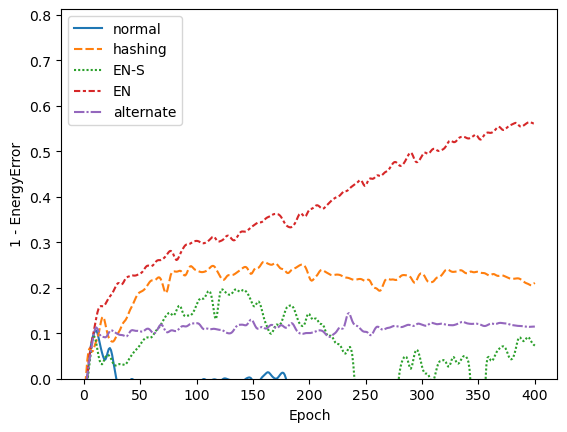

In [81]:
data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = [covered_energy(ground_spectrum[0, 1:], result["normalized_spectrums"][epoch, 1:]) 
                    for epoch in range(len(result["spectrums"]))]
    data[method] = gaussian_filter1d(data[method], sigma=2)
    
g = sns.lineplot(data=data)
g.set_xlabel("Epoch")
g.set_ylabel("1 - EnergyError")
g.set_ylim(0)

## Splitted by degree, colored by method (over whole spectrum)

/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)


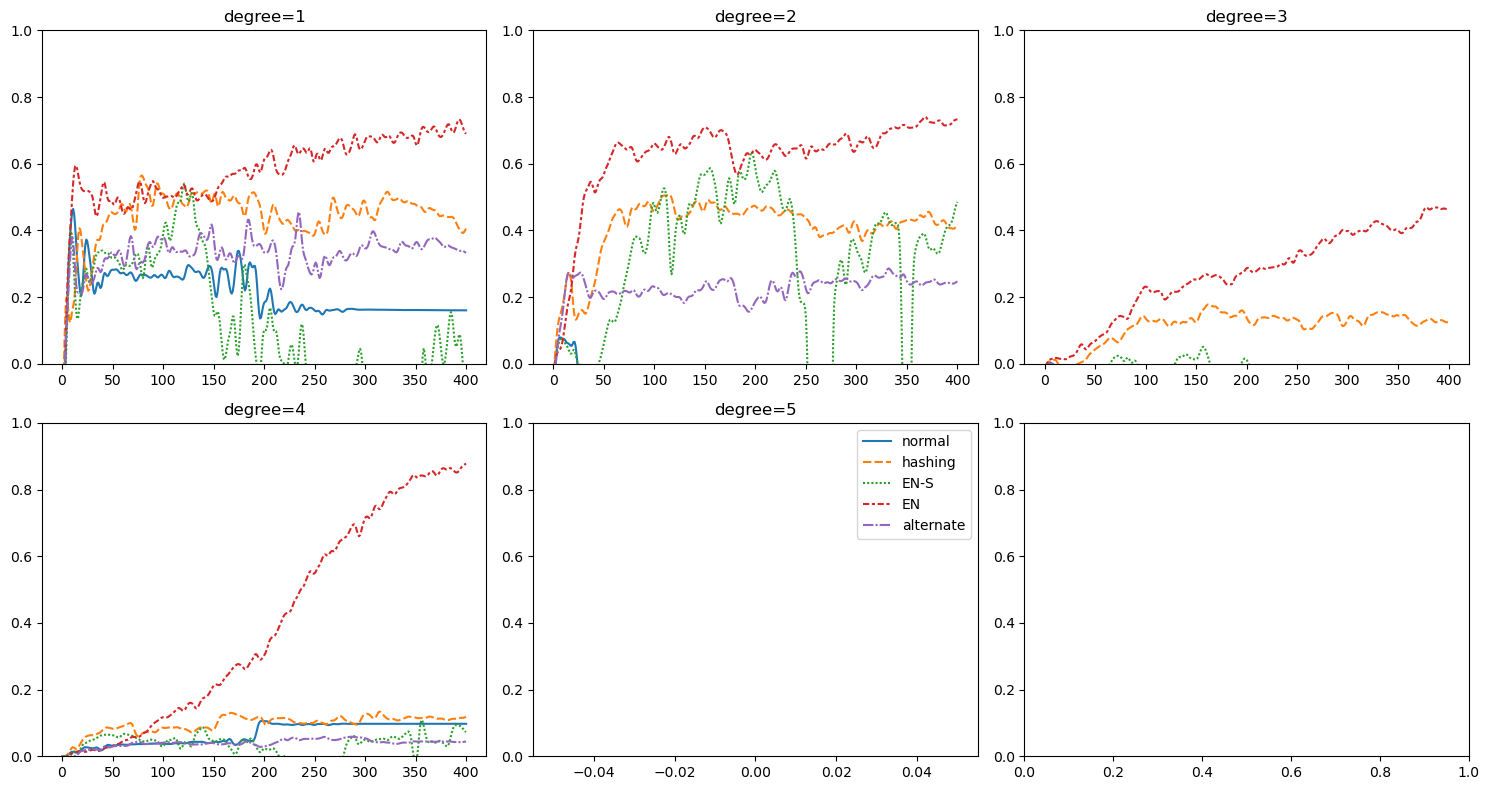

In [82]:
n_col = 3
count = test_d 
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))
                                                         
for i in range(count):
    indices = range(deg_start_inds[i], deg_start_inds[i+1] if i+1 < count else deg_start_inds[i] + 1)
    ax = axes[i//n_col, i%n_col]
    
    data = {}
    for j, (method, result) in enumerate(results.items()):
        data[method] = [covered_energy(ground_spectrum_sorted[0, indices], result["sorted_spectrums"][epoch, indices]) 
                        for epoch in range(len(result["spectrums"]))]
        data[method] = gaussian_filter1d(data[method], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=False if i != count -1 else True)
    ax.set_ylim((0, 1))
    ax.set_title(f"degree={i+1}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()

## Splitted by method, colored by degree (over whole spectrum)

/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)
/scratch/252423528.tmpdir/ipykernel_192504/1317577579.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)


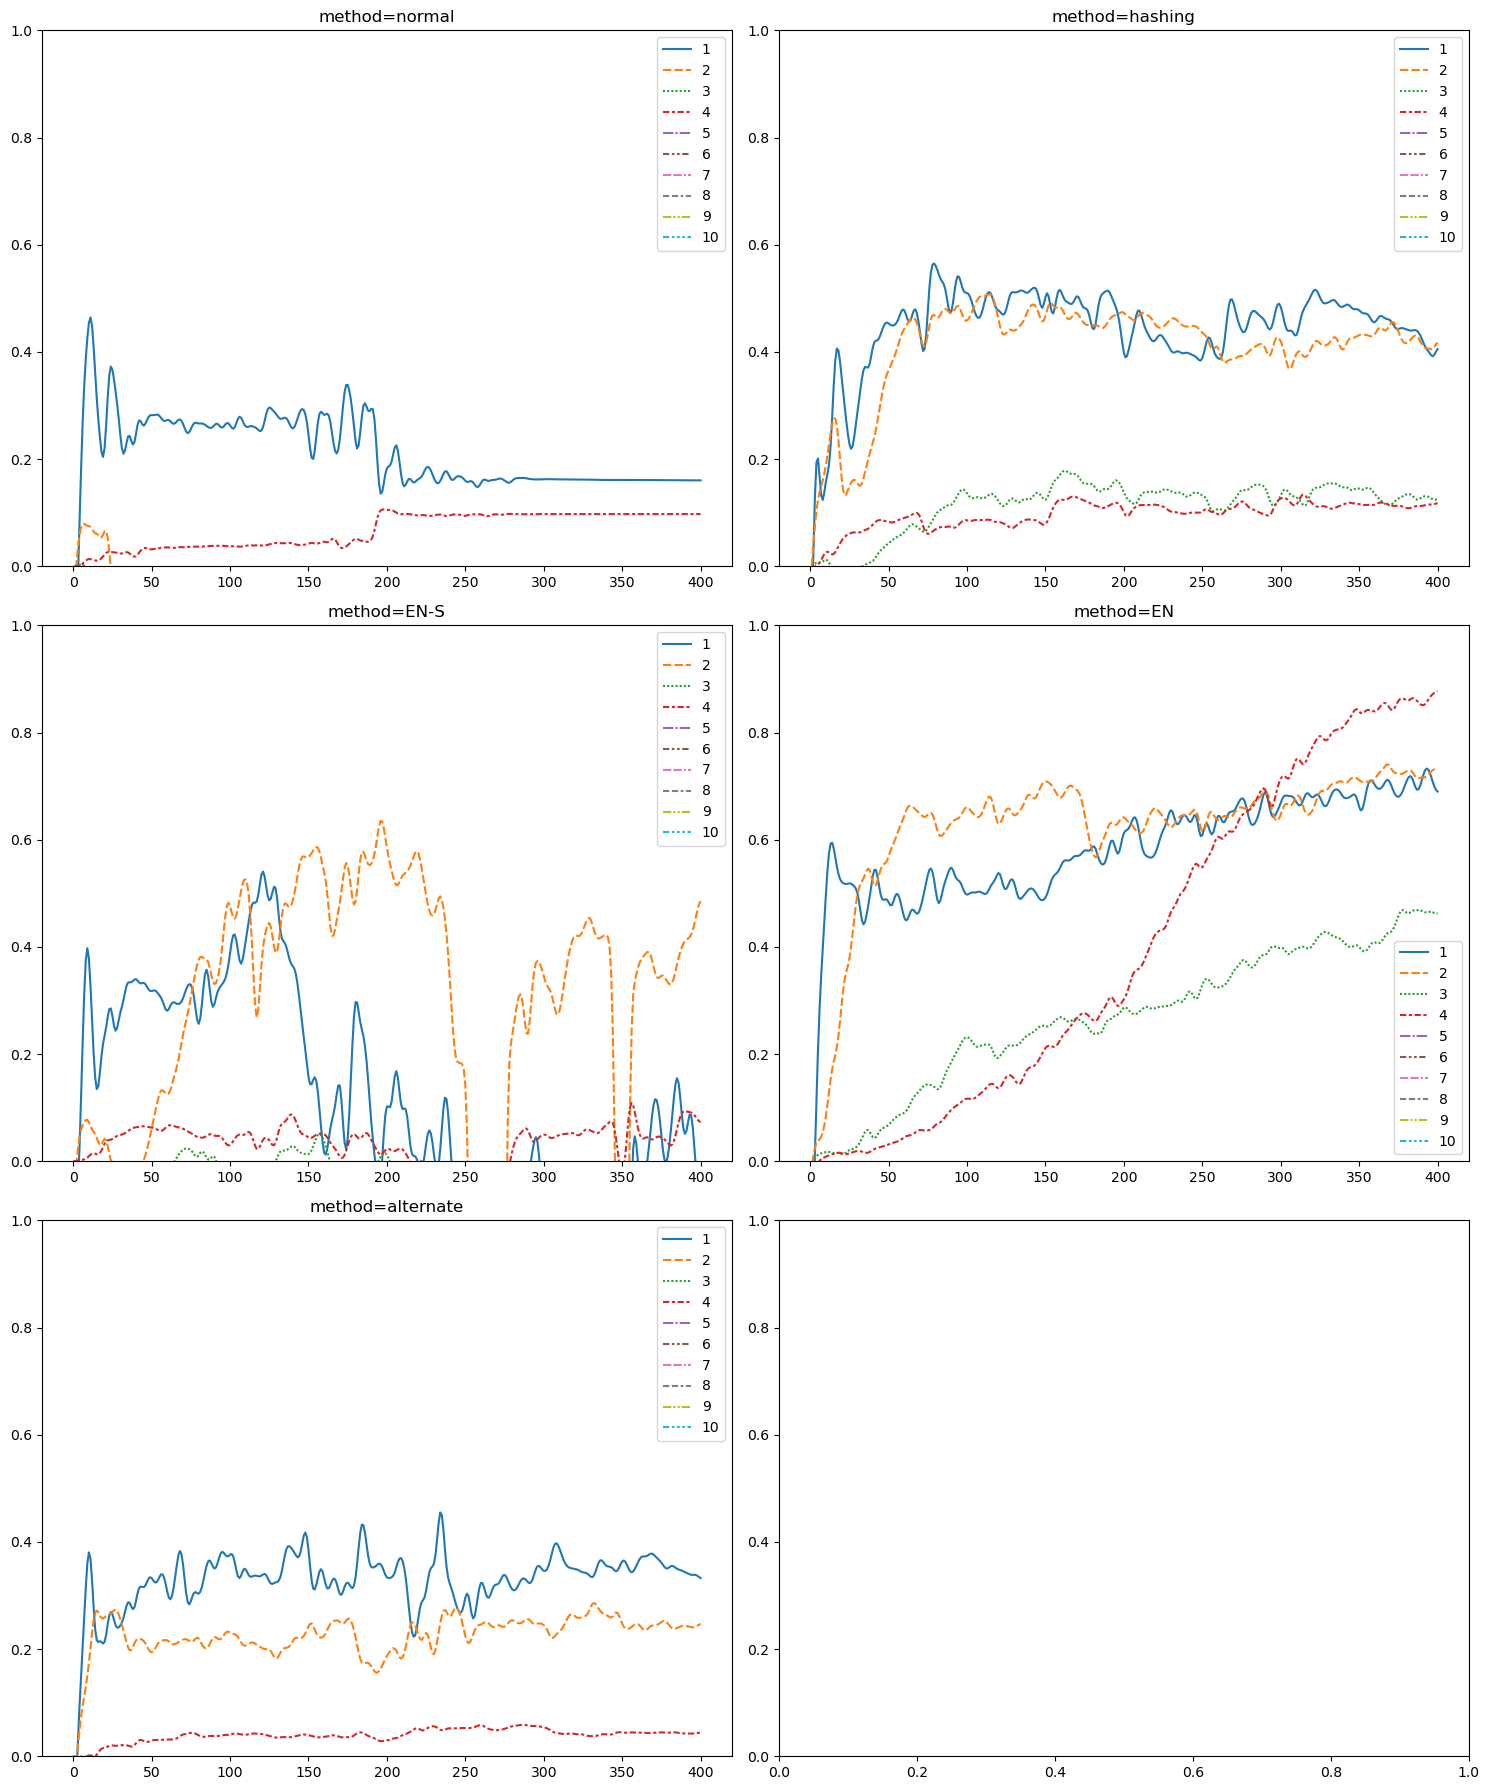

In [83]:
n_col = 2
count = len(results)
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))

for j, (method, result) in enumerate(results.items()):
    ax = axes[j//n_col, j%n_col]
    
    data = {}
    for i in range(len(deg_start_inds)):
        indices = range(deg_start_inds[i], deg_start_inds[i+1] if i+1 < count else deg_start_inds[i] + 1)
        data[i+1] = [covered_energy(ground_spectrum_sorted[0, indices], result["sorted_spectrums"][epoch, indices]) 
                        for epoch in range(len(result["spectrums"]))]
        data[i+1] = gaussian_filter1d(data[i+1], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=True)
    ax.set_ylim((0, 1))
    ax.set_title(f"method={method}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()

# Sparsity evolution

Text(0, 0.5, 'Count of frequencies with significant amplitudes')

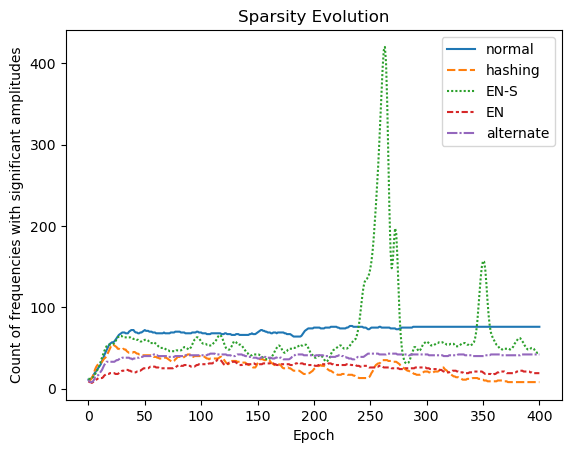

In [84]:
threshold = 5e-2

data = {}
for i, (method, result) in enumerate(results.items()):
    data[method] = np.sum(np.abs(result["normalized_spectrums"]) > threshold, axis=1)
    data[method] = gaussian_filter1d(data[method], sigma=2)    

g = sns.lineplot(data=data)
g.set_title("Sparsity Evolution")
g.set_xlabel("Epoch")
g.set_ylabel("Count of frequencies with significant amplitudes")

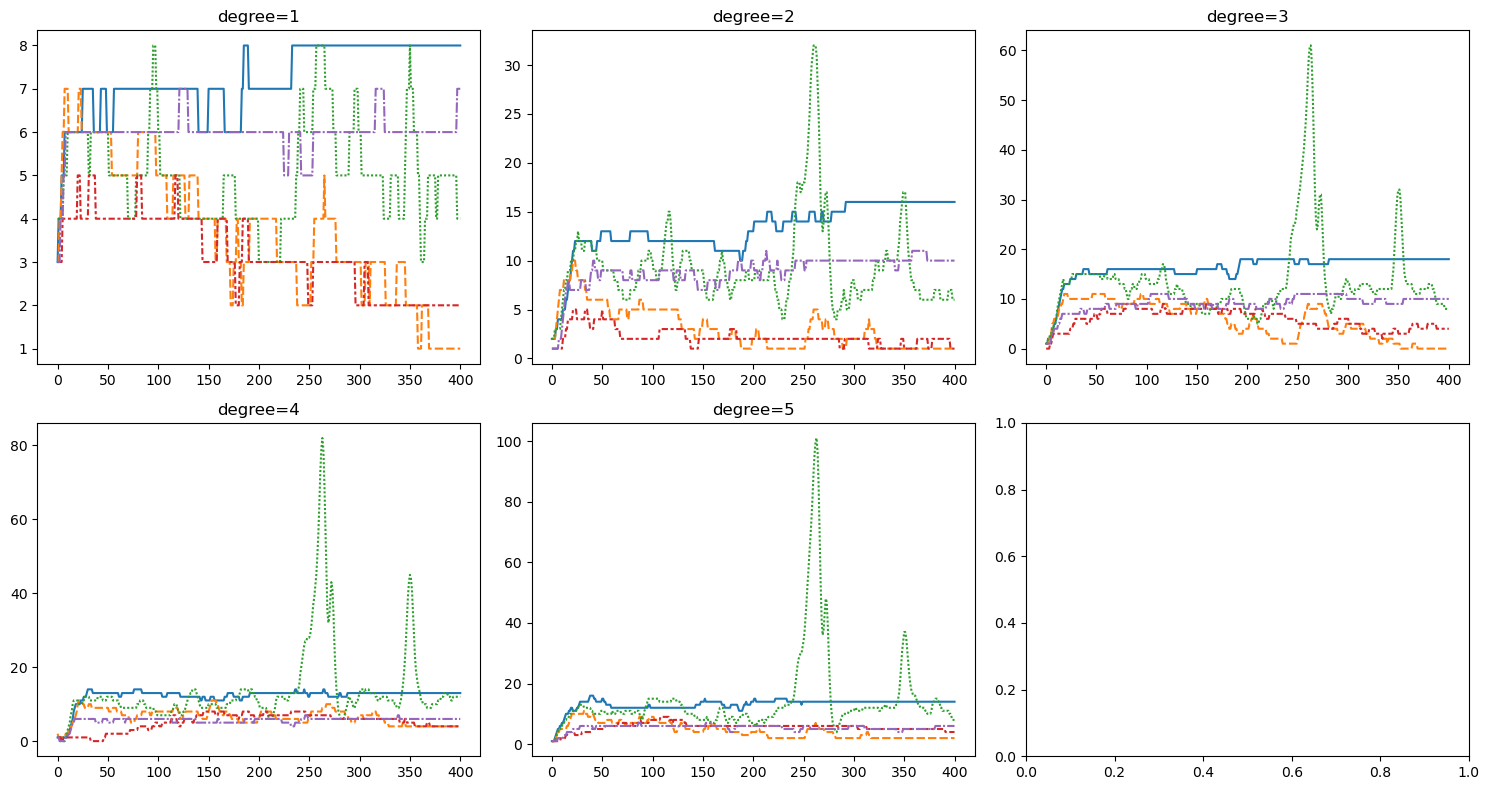

In [85]:
n_col = 3
count = test_d
fig, axes = plt.subplots(math.ceil(count/n_col), n_col, figsize=(15, math.ceil(count/n_col)*(12/n_col)))
                                                         
for i in range(count):
    indices = range(deg_start_inds[i], deg_start_inds[i+1])
    ax = axes[i//n_col, i%n_col]
    
    data = {}
    for j, (method, result) in enumerate(results.items()):
        data[method] = np.sum(np.abs(result["normalized_spectrums"][:, indices]) > threshold, axis=1)
        data[method] = gaussian_filter1d(data[method], sigma=2)

    g = sns.lineplot(data=data, ax=ax, legend=False)
    ax.set_title(f"degree={i+1}")

# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
fig.tight_layout()